# Direct Mail Efficiency Improvement

### This project goal is to improve the efficiency of direct mail marketing.

We use two differnt data sets for this project.

            1) Combined_output: All properties that are mailed in the last 24 months. We have a total of 5M records.

            2) StuckAqcs: All properties that are converted and GrossMargin over each property.

## Important variables:
    - Currentavmvalue
    - equityvalue,
    - EquityPercent,
    - LOO
    - Age

## Methodology:
    - Step1: Since the dataset is huge, sample the data set to create a smaller set.
    - Step2: Transform variables to meet clustering requirments.
    - Step2: Create clusters on the sample data sets. Pickle the model.
    - Step3: Apply the clustering on the whole data set. Create sub clusters of each cluster based on OwnerType and 
                CurrentAVM value quartile.
    - Step4: Compute #mails sent in each subcluster Identified in Step3
    - Step5: Apply the culstering on the converted file. Create subclusters of each cluster based on OwnerType and 
                CurrentAVM value quartile.
    - Step6: Compute Gross Margin of each subcluster identifeid in Step5
    - Step7: Finally compute ROI from outputs of Step4 and Step6 (ROI = GrossMargin/#mail)

In [2]:
# libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from tabulate import tabulate

## Loading the complete Data set

In [3]:
#Load only what is needed
use_cols = [
    "PropertyID",
    "Currentavmvalue",
    "equityValue",
    "EquityPercent",
    "LOO",
    "Age",
    "FinalOwnerType",
    "Beds",
    "FullBaths",
    "HalfBaths",
    "Sqft",
    "building_condition",
    "owneroccupied",
    "multi_owner",
    "Lien"
]

df_combined = pd.read_csv(os.path.join("data", "combined_output.csv"),
    usecols=use_cols,
    low_memory=False
)

# print df shape
print("df_combined shape: ", df_combined.shape)

df_combined shape:  (5300825, 15)


In [4]:
df_combined.head(5)

,PropertyID,Currentavmvalue,equityValue,EquityPercent,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age
0,25364087,171839.0,98193,57,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,24.0
1,26211073,248051.0,159656,64,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,46.0
2,24996618,258259.0,258259,100,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,40.0
3,25606013,134984.0,86997,64,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,35.0
4,26005503,236439.0,151191,63,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,36.0


### check/handle missing data

In [5]:
# check for missing values in percentage
for col in df_combined.columns:
    print(col, round(df_combined[col].isna().sum() / len(df_combined) * 100,2), "%")

PropertyID 0.0 %
Currentavmvalue 0.0 %
equityValue 0.0 %
EquityPercent 0.0 %
FinalOwnerType 0.0 %
owneroccupied 67.96 %
building_condition 99.7 %
multi_owner 67.96 %
Lien 99.84 %
LOO 22.93 %
Beds 83.45 %
FullBaths 69.95 %
HalfBaths 84.36 %
Sqft 69.29 %
Age 0.88 %


In [6]:
# Structurally reliable features (near-complete)
tier1_col = [
   'Currentavmvalue',
   'equityValue',
   'EquityPercent',
   'FinalOwnerType',
   'Age',
   'LOO' 
]

In [7]:
# Data transformation
df_combined["LOO_missing"] = df_combined["LOO"].isna().astype(int)
df_combined["Age_missing"] = df_combined["Age"].isna().astype(int)


In [8]:
# Data transformation 
# because Early tenure differences matter a lot, but Very long tenure differences matter less, so keeping LOO linear, means: “90 → 100 years is as important as 20 → 30 years.” 
# Which is almost certainly false behaviorally.
df_combined["LOO_log"] = np.log1p(df_combined["LOO"])

In [9]:
#Data Tranformation Encode Categorical features
df_combined['is_AO'] = (df_combined['FinalOwnerType'] == 'AO').astype(int)

In [10]:
#Data Transformation
df_combined["Currentavmvalue_log"] = np.log1p(df_combined["Currentavmvalue"])
df_combined["AVM_bin"] = pd.qcut(  # creates Equal-width bins
    df_combined["Currentavmvalue"],
    q=10,
    duplicates="drop"
)

##### Age: Cap at 100 years
##### “Age matters… until it doesn’t.”

stop pretending we can distinguish degrees of ‘very old’ in a meaningful way”

Without capping:
- Age = 300 can dominate distance vs Age = 80
- Even though both are “old” from an investor perspective
- And even though other variables (equity, tenure) already encode the real signal

In [11]:
# Age: Cap at 100 years
# a secondary binary feature
df_combined["is_very_old"] = (df_combined["Age"] > 100).astype(int)  
df_combined["Age_capped"] = df_combined["Age"].clip(upper=100)

<Axes: ylabel='Frequency'>

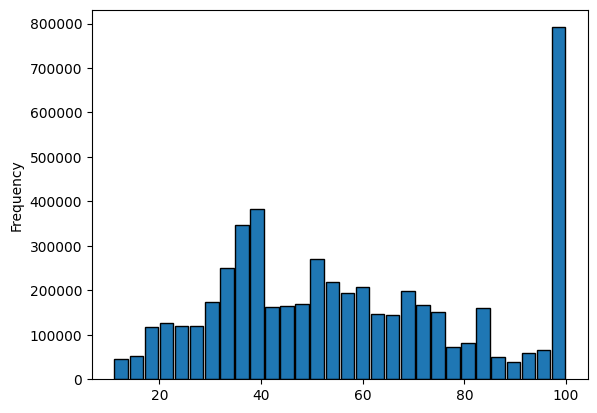

In [12]:
df_combined["Age_capped"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [13]:
# Data cleaning
# 1.drop rows with EquityPercent >100%
df_combined = df_combined[df_combined["EquityPercent"] <= 100]

# EquityPercent == 100 must be treated as a state (is_fully_paid)
df_combined["is_fully_paid"] = (df_combined["EquityPercent"] == 100).astype(int)

# create continuous part of 'EquityPercent'
df_combined["EquityPercent_cont"] = df_combined["EquityPercent"].where(
    df_combined["EquityPercent"] < 100
)

In [14]:
df_combined.columns

Index(['PropertyID', 'Currentavmvalue', 'equityValue', 'EquityPercent',
       'FinalOwnerType', 'owneroccupied', 'building_condition', 'multi_owner',
       'Lien', 'LOO', 'Beds', 'FullBaths', 'HalfBaths', 'Sqft', 'Age',
       'LOO_missing', 'Age_missing', 'LOO_log', 'is_AO', 'Currentavmvalue_log',
       'AVM_bin', 'is_very_old', 'Age_capped', 'is_fully_paid',
       'EquityPercent_cont'],
      dtype='object')

###  Stratified sampling

In [15]:
# Step 4 — Stratified sampling
target_size = 150000
sample_frac = target_size / len(df_combined)

strata_cols = [
    #"FinalOwnerType",
    "AVM_bin",
    "LOO_missing", # to get same fraction of missingness in the sample
    "Age_missing"
]


#--
#- Large strata contribute many rows
#- Small but important strata are preserved
#- Rare combinations don’t disappear
#--
sampled_df = (
    df_combined
    .groupby(strata_cols, group_keys=False, observed=False)
    .apply(lambda x: x.sample(
        frac=sample_frac,
        random_state=42
    ))
)

# step 5 — Save
sampled_df.to_csv(os.path.join("data",
    "combined_output_stratified_sample.csv"),
    index=False
)

C:\Users\Home\AppData\Local\Temp\ipykernel_8432\1434728271.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


NOTE: this sample is a faithful representation of the core investor-targetable population

In [16]:
sampled_df.shape

(150001, 25)

In [17]:
sampled_df["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

In [18]:
df_combined["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.520437
OO    0.479563
Name: proportion, dtype: float64

Final owner type representation in both the samples is the same.

In [19]:
# Is Missingness preserved? (this is critical)
sampled_df[["LOO_missing", "Age_missing"]].mean()

LOO_missing    0.229292
Age_missing    0.008840
dtype: float64

In [20]:
df_combined[["LOO_missing", "Age_missing"]].mean()

LOO_missing    0.229285
Age_missing    0.008838
dtype: float64

LOO_missing and Age_missing have same distribution in both sample and combined data set.

In [21]:
# AVM distribution sanity
sampled_df["Currentavmvalue"].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

In [22]:
df_combined['Currentavmvalue'].describe()

count    5.300800e+06
mean     3.617401e+05
std      1.705190e+05
min      4.000000e+04
25%      2.396440e+05
50%      3.300000e+05
75%      4.455102e+05
max      2.172704e+06
Name: Currentavmvalue, dtype: float64

Note:

the max in the sample vs original df shows Minor discrepancy.

Since all other quartiles are same between sample and combined dataset, and the max is an outlier, we can conclude that
the sample and combined data set are statistically same.

### Investigation

In [23]:
sampled_df['FinalOwnerType'].value_counts(normalize=True, dropna=False)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

==> 'FinalOwnerType' is dangerous and valuable. should not let FinalOwnerType directly drive distance in the first clustering pass. Should be excluded from distance metric to avoid trivial soltion:
“Cluster 1 = AO, Cluster 2 = OO”

In [24]:
sampled_df.groupby("FinalOwnerType")[
    ["EquityPercent", "LOO_missing"]
].mean()

,EquityPercent,LOO_missing
FinalOwnerType,,
AO,84.367946,0.221650
OO,74.976164,0.237619


Conclusion:
- Missing LOO is not explained by ownership type. 22% of properties in both the segments are long tenured.
- AO tend to be further along the financial lifecycle/ But many OO are also high-equity/ And many AO are still leveraged

so 'FinalOwnerType' should inform ranking, not geometry. It carries secondary interpretation.

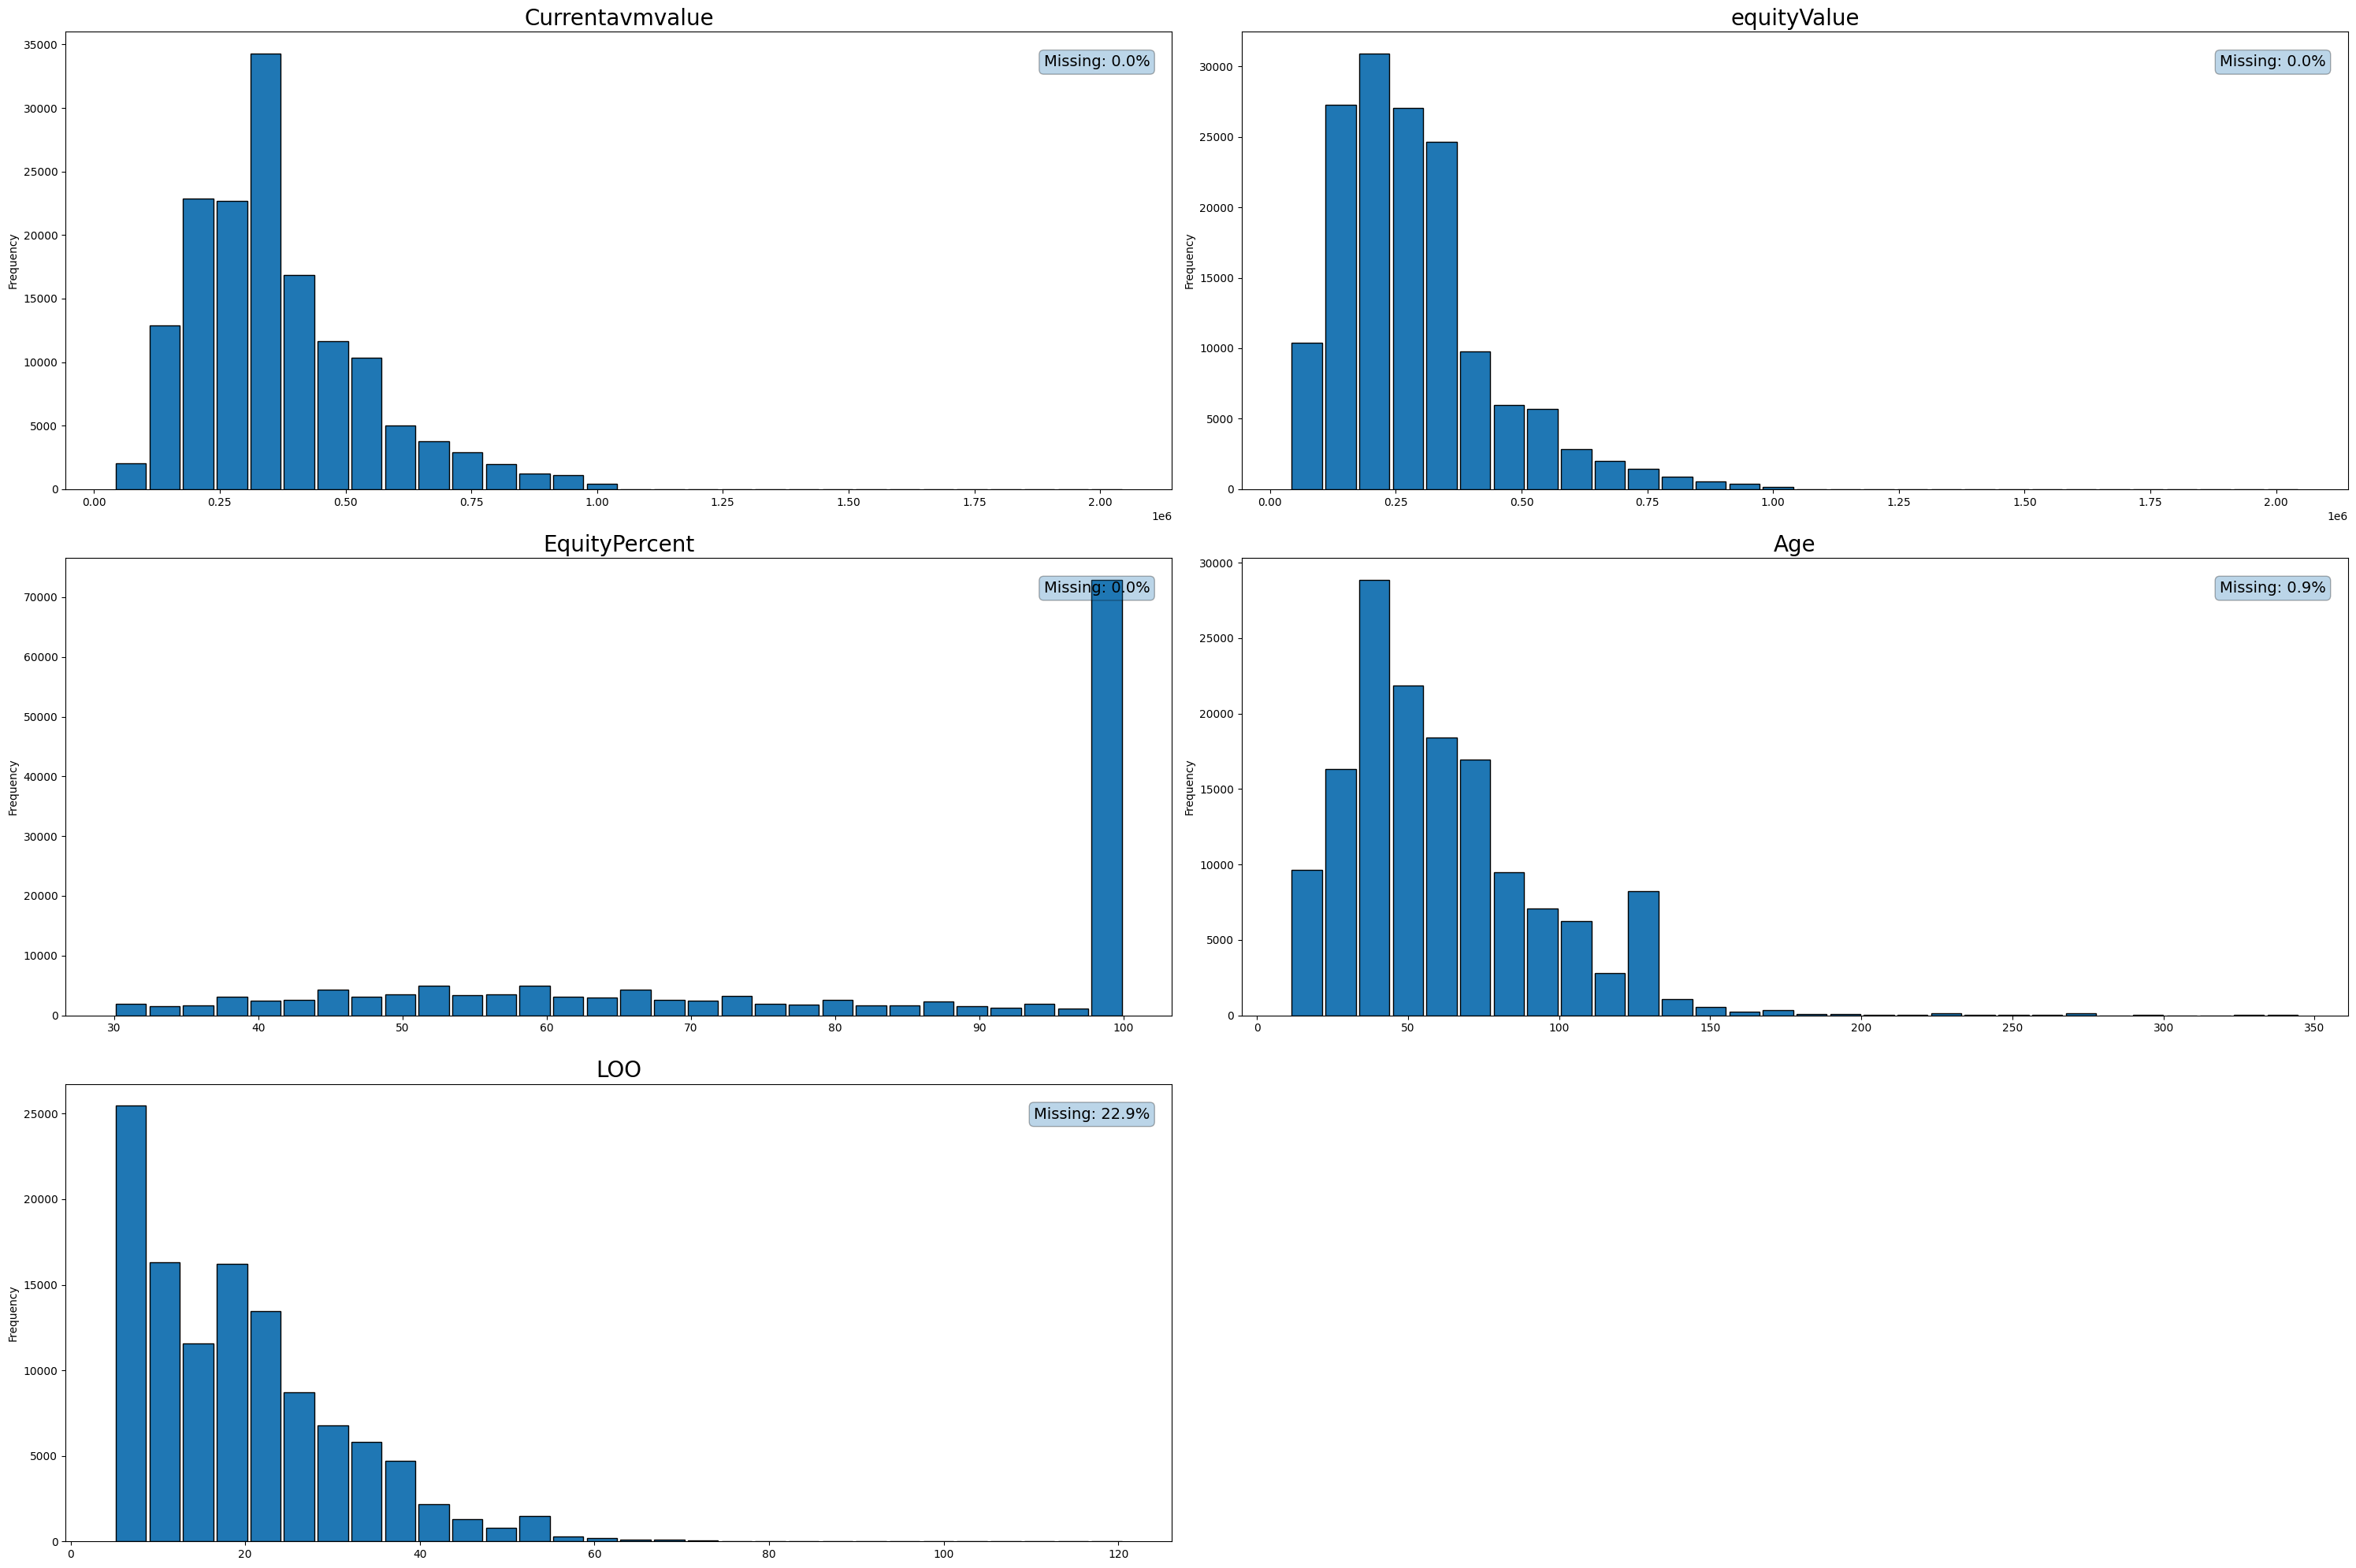

In [25]:
# make a 2 by 2 plot
plt.figure(figsize=(30, 20))
# tier1_col exclufing final owner type
col = [c for c in tier1_col if c != "FinalOwnerType"]

for i, col in enumerate(col):
    ax = plt.subplot(3, 2, i + 1)
    ax.set_title(col,fontsize=20)
    sampled_df[col].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

    missing_pct = sampled_df[col].isna().mean() * 100

    ax.text(
        0.98, 0.95,
        f"Missing: {missing_pct:.1f}%",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3)
    )
    plt.tight_layout()

### Observation:

### 1. EquityPercent = 100 is a proxy for ownership psychology, not just finance.

From a behavioral standpoint, these owners are different:

- Often long LOO
- Often older properties
- Frequently absentee owners
- Emotionally detached from the property
- Much easier investor conversations

==> EquityPercent == 100, is_fully_paid? or EquityPercent_capped?

In [26]:
# How many are fully paid?
(sampled_df['is_fully_paid']).mean()

0.481176792154719

48% of the properties are fully paid. This segment is much more prone to sell properties than others.

In [27]:
# Relationship with LOO
sampled_df.groupby(sampled_df['is_fully_paid'])["LOO"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fully_paid,,,,,,,,
0,67382.0,16.928916,9.913877,4.982888,8.629706,15.583847,22.102669,80.027379
1,48225.0,22.708482,12.867009,4.988364,11.463381,21.177276,31.589322,120.596851


Text(0.3, 0.3, 'Mean: 22.7')

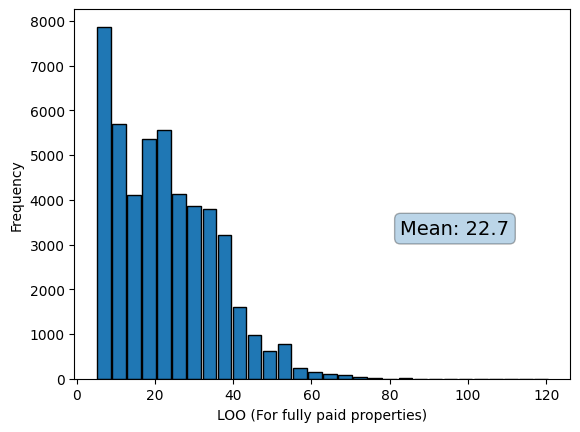

In [28]:
# plot LOO histogram for fully paid

sampled_df[sampled_df['is_fully_paid']==1]["LOO"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

# set labels
plt.xlabel("LOO (For fully paid properties)")
plt.ylabel("Frequency")

meanLoo = round(sampled_df[sampled_df['is_fully_paid']==1]["LOO"].mean(),1)
# print the mean value
#plt.text(100, 5000, f'mean LOO:{meanLoo}')
plt.text(
        0.3, 0.3,
        f"Mean: {meanLoo:.1f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))

 Is fully paid and LOO less than 20 yrs, considered well to do segment of owner?.
 
 It is possible that they have less propensity to sell to an investor. 
 
 We will know once we do ROI analysis.

In [29]:
sampled_df.head(5)

,PropertyID,Currentavmvalue,equityValue,EquityPercent,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age,LOO_missing,Age_missing,LOO_log,is_AO,Currentavmvalue_log,AVM_bin,is_very_old,Age_capped,is_fully_paid,EquityPercent_cont
5067265,62191438,99000.0,99000,100,AO,0.0,NaN,1.0,NaN,34.116359,NaN,1.0,NaN,744.0,77.0,0,0,3.558667,1,11.502885,"(39999.999, 174000.0]",0,77.0,1,NaN
2097214,62707548,172000.0,172000,100,OO,NaN,NaN,NaN,NaN,50.773443,NaN,NaN,NaN,NaN,82.0,0,0,3.946877,0,12.055256,"(39999.999, 174000.0]",0,82.0,1,NaN
2819727,64478076,132000.0,132000,100,AO,NaN,NaN,NaN,NaN,6.253251,NaN,NaN,NaN,NaN,94.0,0,0,1.981450,1,11.790565,"(39999.999, 174000.0]",0,94.0,1,NaN
4411295,64621859,80000.0,80000,100,AO,0.0,NaN,1.0,NaN,7.928816,NaN,1.0,NaN,960.0,71.0,0,0,2.189284,1,11.289794,"(39999.999, 174000.0]",0,71.0,1,NaN
2109695,64326849,147000.0,147000,100,AO,NaN,NaN,NaN,NaN,43.022587,NaN,NaN,NaN,NaN,100.0,0,0,3.784703,1,11.898195,"(39999.999, 174000.0]",0,100.0,1,NaN


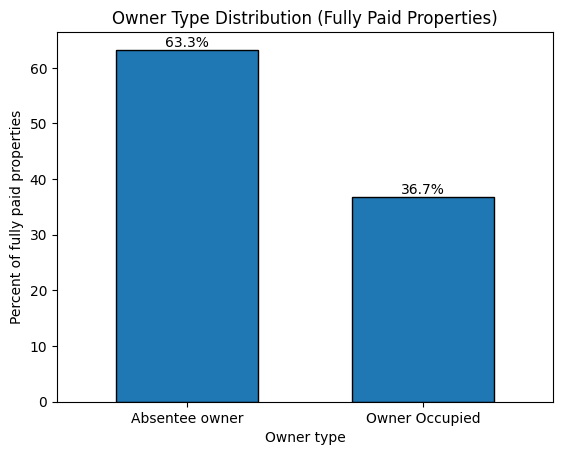

In [30]:
# plot AO histograms for fully paid

ownership_pct = sampled_df[sampled_df["is_fully_paid"] == 1]["is_AO"].value_counts(normalize=True) * 100


ax = ownership_pct.rename({1: "Absentee owner", 0: "Owner Occupied"}).plot.bar(
    edgecolor="black",
    width=0.6
)

ax.set_ylabel("Percent of fully paid properties")
ax.set_xlabel("Owner type")
ax.set_title("Owner Type Distribution (Fully Paid Properties)")

# annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom"
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()


==> Conclusion: 
- Fully paid ownership and absentee ownership are correlated, but not redundan
- Baseline rate of AO is 52%
- Being fully paid increases the likelihood of being absentee
- is_AO is a good secondary explanatory variable
    - If you had let is_AO into the distance metric --> Clusters would lean heavily toward AO/OO separation

In investor terms, fully paid owners are:
- More likely to be absentee (63.3%)
- More likely to sell directly
- Less constrained by lenders
- But one in three fully paid owners still live in the home (36.7%)

### Missing LOO is not “unknown” — it’s a proxy state

In [31]:
df_missing_loo = sampled_df[sampled_df["LOO_missing"]==1]
df_non_missing_loo = sampled_df[sampled_df["LOO_missing"]==0]

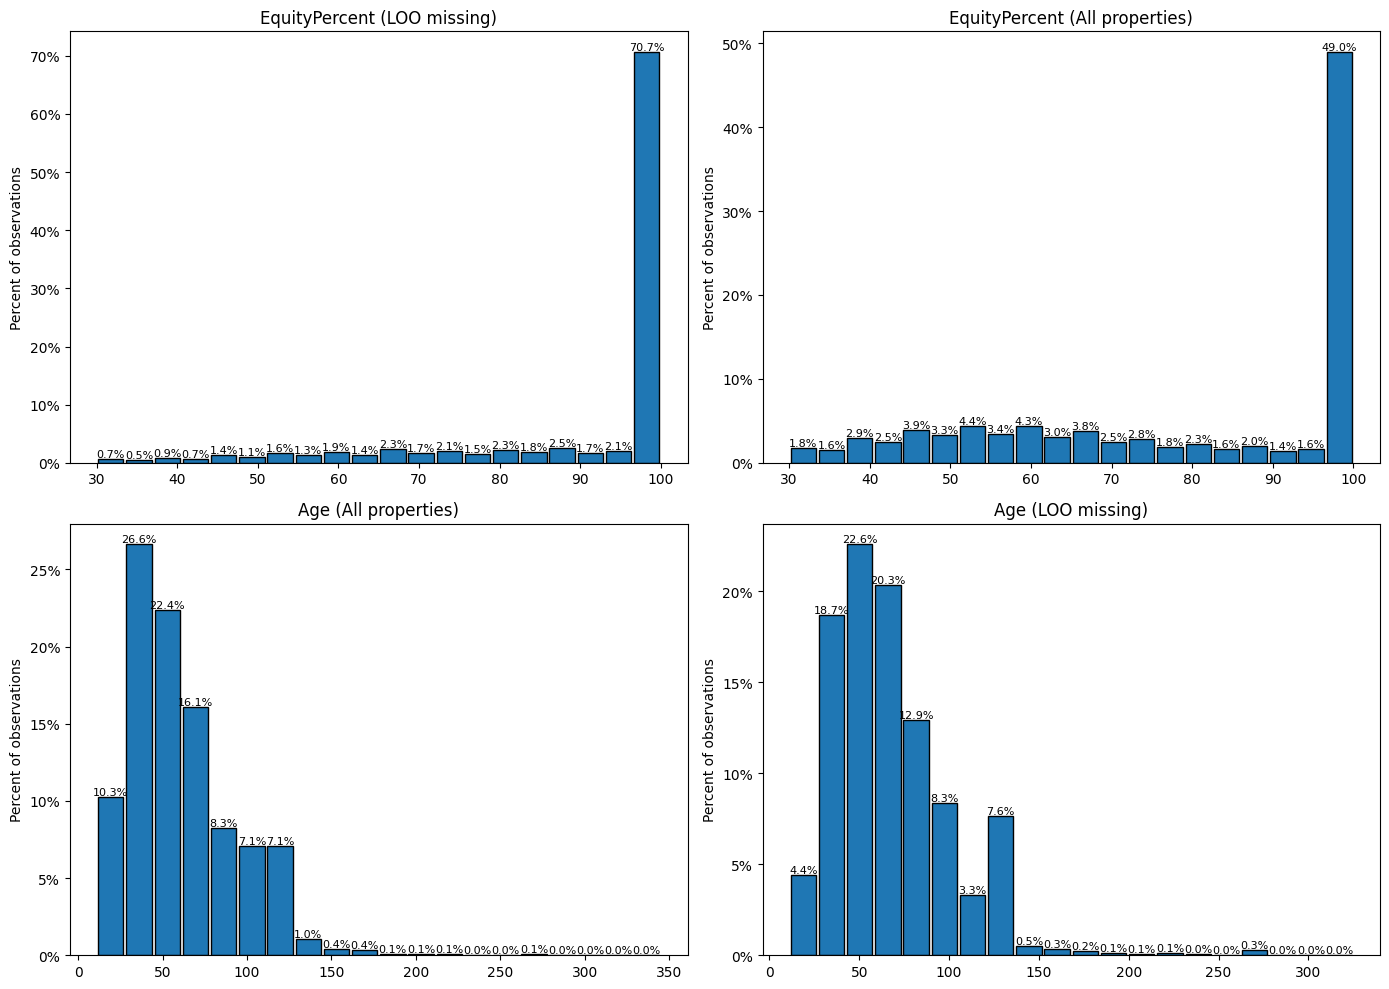

In [32]:
def percent_hist(ax, data, bins, xlabel, title):
    weights = np.ones(len(data)) / len(data) * 100

    ax.hist(
        data,
        bins=bins,
        weights=weights,
        edgecolor="black",
        rwidth=0.9
    )

    #ax.set_xlabel(xlabel)
    ax.set_ylabel("Percent of observations")
    ax.set_title(title)
    ax.yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")

    # annotate bars
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.1f}%",
                (patch.get_x() + patch.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=8
            )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Row 1: EquityPercent ---
percent_hist(
    ax=axes[0, 0],
    data=df_missing_loo["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (LOO missing)"
)

percent_hist(
    ax=axes[0, 1],
    data=sampled_df["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (All properties)"
)

# --- Row 2: Age ---
percent_hist(
    ax=axes[1, 0],
    data=sampled_df["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (All properties)"
)

percent_hist(
    ax=axes[1, 1],
    data=df_missing_loo["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (LOO missing)"
)

plt.tight_layout()
plt.show()


==> conclusion:
- LOO has two meanings depending on whether it exists.
    - Majority of missing LOO are fully paid properties ~ 71%
- Age distribution does not matter in LOO (Missing LOO is not about the house being older)

<Axes: ylabel='Frequency'>

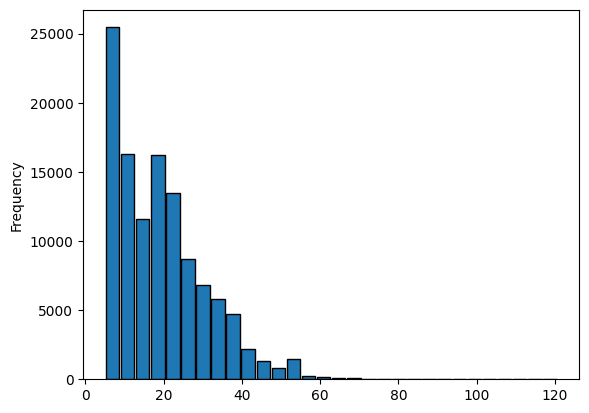

In [33]:
sampled_df[sampled_df['LOO'].notna()]['LOO'].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [34]:
sampled_df['Currentavmvalue'].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

## Assembling a model of ownership behavior

#### Step 1 — Sanity check

In [35]:
cluster_features = [
    "Currentavmvalue_log",
    "is_fully_paid",
    "EquityPercent_cont",
    "LOO_log",
    "LOO_missing",
    "Age_capped"
]
X = sampled_df[cluster_features]
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 150001 entries, 5067265 to 5282879
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Currentavmvalue_log  150001 non-null  float64
 1   is_fully_paid        150001 non-null  int32  
 2   EquityPercent_cont   77824 non-null   float64
 3   LOO_log              115607 non-null  float64
 4   LOO_missing          150001 non-null  int32  
 5   Age_capped           148675 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 6.9 MB


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,150001.000000,150001.000000,77824.000000,115607.000000,150001.000000,148675.000000
mean,12.690348,0.481177,61.207417,2.851084,0.229292,58.175732
std,0.475768,0.499647,17.229000,0.578297,0.420379,25.604770
min,10.596660,0.000000,30.000000,1.788903,0.000000,11.000000
25%,12.385970,0.000000,48.000000,2.351929,0.000000,37.000000
50%,12.706851,0.000000,59.000000,2.931458,0.000000,54.000000
75%,13.008076,1.000000,74.000000,3.280870,0.000000,77.000000
max,14.531650,1.000000,99.000000,4.800711,1.000000,100.000000


In [36]:
X.isnull().sum()

Currentavmvalue_log        0
is_fully_paid              0
EquityPercent_cont     72177
LOO_log                34394
LOO_missing                0
Age_capped              1326
dtype: int64

In [538]:
max_loo_log = max(X['LOO_log'])
max_equitypercent_cont = 100
max_age_capped = 100

#### Step 2 — Handle intentional NaNs
- When LOO_log missing properties is properties with longer LOO, so we are replacing them with properties with highest LOO_log value.
- When EquityPercent_cont is missing they are peroperties with 100% equity, so replace them with 100% equity.

In [539]:
X.loc[X['LOO_log'].isna(),
            'LOO_log'] = max_loo_log
X.loc[X['EquityPercent_cont'].isna(),
            'EquityPercent_cont'] = max_equitypercent_cont
X.loc[X['Age_capped'].isna(),
                'Age_capped'] = max_age_capped

In [540]:
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 150001 entries, 5067265 to 5282879
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Currentavmvalue_log  150001 non-null  float64
 1   is_fully_paid        150001 non-null  int32  
 2   EquityPercent_cont   150001 non-null  float64
 3   LOO_log              150001 non-null  float64
 4   LOO_missing          150001 non-null  int32  
 5   Age_capped           150001 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 6.9 MB


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000
mean,12.690348,0.481177,79.873508,3.298117,0.229292,58.545456
std,0.475768,0.499647,23.015020,0.964085,0.420379,25.790222
min,10.596660,0.000000,30.000000,1.788903,0.000000,11.000000
25%,12.385970,0.000000,59.000000,2.527616,0.000000,37.000000
50%,12.706851,0.000000,94.000000,3.126827,0.000000,54.000000
75%,13.008076,1.000000,100.000000,3.873096,0.000000,78.000000
max,14.531650,1.000000,100.000000,4.800711,1.000000,100.000000


In [541]:
X.isnull().sum()

Currentavmvalue_log    0
is_fully_paid          0
EquityPercent_cont     0
LOO_log                0
LOO_missing            0
Age_capped             0
dtype: int64

#### Step 3 — Scaling
we have
- Continuous variables (log AVM, LOO_log, Age_capped) ==> comparable in scale
- Binary variables (is_fully_paid, LOO_missing) ==> retain meaning (0 vs 1)

In [542]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [543]:
# X_scaled is a numpy array
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=cluster_features,
    index=sampled_df.index
)

In [544]:
X_scaled_df.describe()


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,5.832854e-15,2.728466e-17,7.882235e-17,3.486373e-16,1.273284e-16,1.110334e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-4.400667e+00,-9.630363e-01,-2.167005e+00,-1.565441e+00,-5.454429e-01,-1.843552e+00
25%,-6.397629e-01,-9.630363e-01,-9.069545e-01,-7.992072e-01,-5.454429e-01,-8.354146e-01
50%,3.468726e-02,-9.630363e-01,6.137965e-01,-1.776723e-01,-5.454429e-01,-1.762479e-01
75%,6.678251e-01,1.038383e+00,8.744967e-01,5.964000e-01,-5.454429e-01,7.543405e-01
max,3.870184e+00,1.038383e+00,8.744967e-01,1.558575e+00,1.833373e+00,1.607380e+00


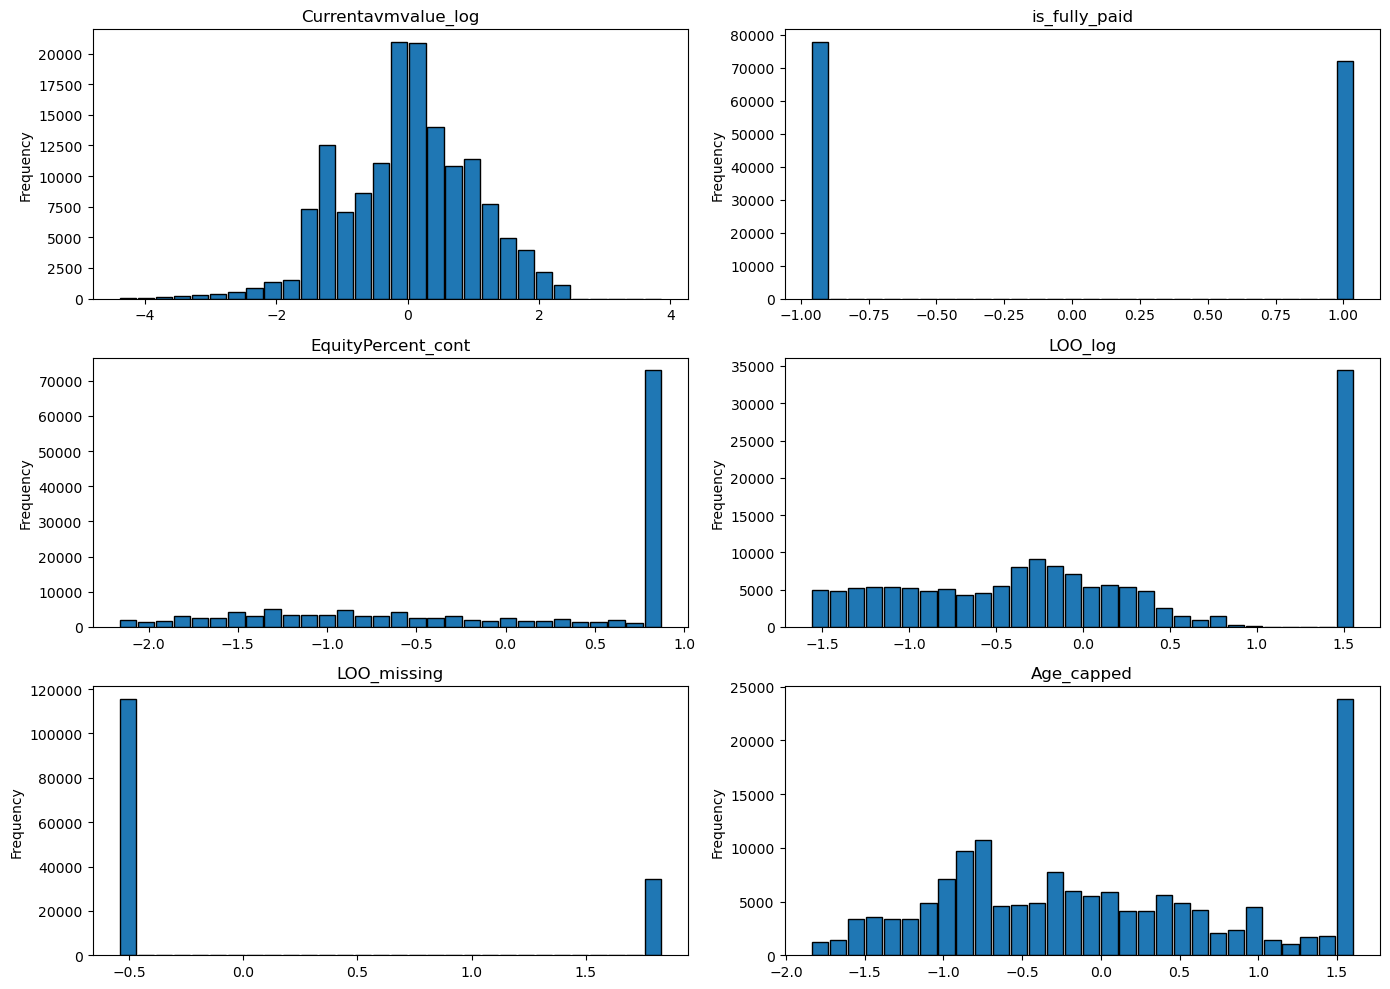

In [545]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cluster_features):
    ax = plt.subplot(3, 2, i + 1)
    X_scaled_df[col].plot.hist(
        bins=30,
        edgecolor="black",
        rwidth=0.9,
        ax=ax
    )
    ax.set_title(col)

plt.tight_layout()
plt.show()

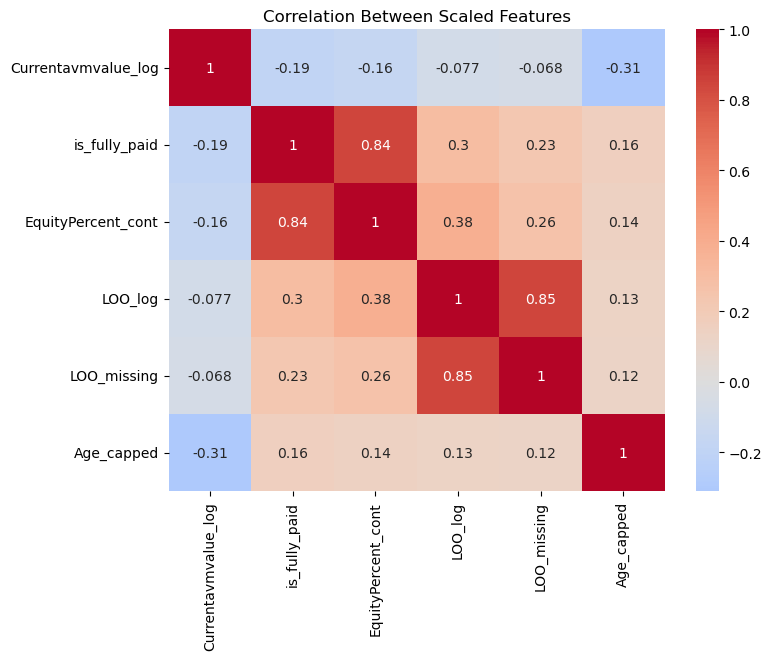

In [546]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    X_scaled_df.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Between Scaled Features")
plt.show()

==> Conclusion: the high correlation is by design, not a problem. e.g.:
- is_fully_paid: Binary state
- EquityPercent_cont: Continuous degree


---

### Algorithm 1: KMeans (first try)

In [547]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,
    random_state=42,
    n_init=20
)

labels = kmeans.fit_predict(X_scaled)

sampled_df["cluster"] = labels

In [548]:
sampled_df.groupby("cluster")[cluster_features].mean()

,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
cluster,,,,,,
0,12.860991,1.0000,NaN,3.004355,0.0,43.002537
1,12.729018,0.0000,69.915055,NaN,1.0,58.102295
2,12.507731,0.0000,60.189034,2.764749,0.0,80.585184
3,12.271966,0.9986,95.933333,3.006299,0.0,82.292917
4,12.956134,0.0000,59.629298,2.725889,0.0,37.724739
5,12.588407,1.0000,NaN,NaN,1.0,66.219622


In [549]:
sampled_df.groupby("cluster")["is_AO"].mean()

cluster
0    0.744398
1    0.393794
2    0.380217
3    0.582027
4    0.448017
5    0.552146
Name: is_AO, dtype: float64

==> conclusion: Clusters are not trivially “AO vs OO”

In [550]:
sampled_df.groupby("cluster").size()

cluster
0    26823
1    10442
2    25588
3    21432
4    41764
5    23952
dtype: int64

### ==> Result interpretation of Algo 1: KMeans (first try)

#### 1. First sanity verdict

Before details:

* ✅ No single cluster dominates (sizes are reasonable)
* ✅ No cluster is tiny/noise
* ✅ Clusters are not trivially “AO vs OO”
* ✅ Equity regime, tenure regime, and AVM are all participating

This means:

> **The geometry is healthy.**

Now we can reason.
## 2. NEXT

### **Step 1 — Stability check **

Run KMeans with different `k` values:

* `k = 5, 6, 7, 8`

Then check:

* Does Cluster 5 persist?
* Does it split meaningfully or dissolve?
* Do legacy clusters remain stable?

If your best cluster vanishes at `k=7`, that’s a warning.

In [551]:
# 1. Stability check
from sklearn.cluster import KMeans

k_values = [5, 6, 7, 8]
cluster_results = {}

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20
    )
    labels = km.fit_predict(X_scaled)
    cluster_results[k] = labels

# remove previous clustring column
sampled_df.drop("cluster", axis=1, inplace=True)

for k, labels in cluster_results.items():
    sampled_df[f"cluster_k{k}"] = labels


In [552]:
# Compare cluster profiles
for k in k_values:
    print(f"\n=== k = {k} ===")
    display(
        sampled_df
        .groupby(f"cluster_k{k}")[cluster_features + ["is_AO"]]
        .mean()
    )


=== k = 5 ===


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster_k5,,,,,,,
0,12.956228,0.000000,59.603214,2.725778,0.000741,37.717955,0.448058
1,12.630406,0.697029,70.016905,NaN,1.000000,63.772690,0.504118
2,12.860432,0.999963,98.000000,3.004431,0.000000,42.939706,0.744270
3,12.507694,0.000000,60.204474,2.764956,0.000000,80.610834,0.380124
4,12.273618,0.998695,95.928571,3.006219,0.000000,82.310440,0.582417



=== k = 6 ===


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster_k6,,,,,,,
0,12.860991,1.0000,NaN,3.004355,0.0,43.002537,0.744398
1,12.729018,0.0000,69.915055,NaN,1.0,58.102295,0.393794
2,12.507731,0.0000,60.189034,2.764749,0.0,80.585184,0.380217
3,12.271966,0.9986,95.933333,3.006299,0.0,82.292917,0.582027
4,12.956134,0.0000,59.629298,2.725889,0.0,37.724739,0.448017
5,12.588407,1.0000,NaN,NaN,1.0,66.219622,0.552146



=== k = 7 ===


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster_k7,,,,,,,
0,12.860980,1.000000,NaN,3.004411,0.0,42.972700,0.744356
1,12.950214,0.000000,49.273933,2.480212,0.0,36.769919,0.423153
2,12.588407,1.000000,NaN,NaN,1.0,66.219622,0.552146
3,12.481605,0.000000,58.158165,2.727863,0.0,83.137394,0.364411
4,12.729018,0.000000,69.915055,NaN,1.0,58.102295,0.393794
5,12.272433,0.997904,96.622222,3.006555,0.0,82.281280,0.581994
6,12.915402,0.000000,76.336300,3.113756,0.0,43.727775,0.488809



=== k = 8 ===


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster_k8,,,,,,,
0,12.322368,0.989990,91.522124,NaN,1.0,84.664455,0.456462
1,12.920004,0.000000,76.542981,3.117720,0.0,44.268364,0.487989
2,12.948309,0.000000,49.431569,2.484335,0.0,36.663169,0.423728
3,12.860853,1.000000,NaN,3.004536,0.0,42.954945,0.744335
4,12.736983,0.000000,69.678672,NaN,1.0,57.682908,0.396263
5,12.272912,0.997905,96.800000,3.006444,0.0,82.285191,0.582049
6,12.818287,1.000000,NaN,NaN,1.0,50.755542,0.633297
7,12.477343,0.000000,57.999275,2.724536,0.0,83.075533,0.364567


==> Conclusion:
- k = 5 → too coarse
- k = 6 → minimum viable resolution
- k = 7, 8 → refinement, not distortion

In [553]:
# 2. Compute their membership overlap

gold_k6 = sampled_df.loc[
    (sampled_df["cluster_k6"] == 5)  # 5 is the gold cluster id in k=6
].index

gold_k7 = sampled_df.loc[
    (sampled_df["cluster_k7"] == 0)  # 0 is the gold cluster id in k=7
].index

overlap = len(gold_k6.intersection(gold_k7)) / len(gold_k6)
overlap

0.0

==> Conclusion:

- high overlap means: The same properties are being grouped together
- Increasing k is not changing membership
- The model is just refining the rest of the space by increasing k

So, This cluster is not an artifact of k. It is a true basin in the data geometry.

# Applying Clusters to conversions

In [554]:
# read csv file
df_stuckAcqs = pd.read_csv(os.path.join("data", "StuckAcqs_4thDecember2025_analysis.csv"))

# print df length
print("df_stuckAcqs shape: ", df_stuckAcqs.shape)

df_stuckAcqs shape:  (340, 23)


In [555]:
df_stuckAcqs.columns

Index(['FA Prop Id', 'Prop Address', 'Unit', 'Prop City', 'Prop State',
       'Prop Zip', 'Address', 'FinalownerOccupancy', 'Acq Ratify Date',
       'Stage', 'Acq Price', 'Gross Margin', 'Mailing Address', 'Mailing City',
       'Mailing State', 'Mailing zip', 'AVM', 'Total Mortgage', 'Equity',
       'LOO', 'Age', 'ListSource', 'ListType'],
      dtype='object')

In [556]:
df_stuckAcqs = df_stuckAcqs[~df_stuckAcqs['AVM'].isnull()]
df_stuckAcqs['Equity'] = pd.to_numeric(df_stuckAcqs['Equity'])*100

In [557]:
df_stuckAcqs[['AVM','Equity','LOO','Age']].describe()

,AVM,Equity,LOO,Age
count,2.640000e+02,264.000000,131.000000,253.000000
mean,3.234155e+05,87.916667,15.145038,56.051383
std,1.758255e+05,20.627989,7.413213,31.917076
min,2.283500e+04,23.000000,1.000000,6.000000
25%,2.169155e+05,83.000000,10.000000,35.000000
50%,3.112715e+05,100.000000,15.000000,51.000000
75%,3.820630e+05,100.000000,20.500000,71.000000
max,1.602447e+06,100.000000,34.000000,271.000000


In [558]:
print("Stucks with Missing Avm values:{}".format(df_stuckAcqs['AVM'].isnull().sum()))
# dropping properties with missing AVM
df_stuckAcqs = df_stuckAcqs[~df_stuckAcqs['AVM'].isnull()]

Stucks with Missing Avm values:0


In [559]:
df_stuckAcqs['Currentavmvalue_log']= np.log1p(df_stuckAcqs['AVM'])
df_stuckAcqs['is_fully_paid'] = (df_stuckAcqs["Equity"] == 100).astype(int)
df_stuckAcqs['EquityPercent_cont'] = df_stuckAcqs['Equity'].where(df_stuckAcqs['Equity']<100)
df_stuckAcqs['LOO_log']= np.log1p(df_stuckAcqs['LOO'])
df_stuckAcqs['LOO_missing'] = (df_stuckAcqs['LOO'].isna()).astype(int)
df_stuckAcqs["Age_capped"] = df_stuckAcqs["Age"].clip(upper=100)

In [560]:
df_stuckAcqs[cluster_features].isnull().sum()

Currentavmvalue_log      0
is_fully_paid            0
EquityPercent_cont     182
LOO_log                133
LOO_missing              0
Age_capped              11
dtype: int64

In [561]:
df_stuckAcqs.loc[df_stuckAcqs['LOO_log'].isna(),
            'LOO_log'] = max_loo_log
df_stuckAcqs.loc[df_stuckAcqs['EquityPercent_cont'].isna(),
            'EquityPercent_cont'] = max_equitypercent_cont
df_stuckAcqs.loc[df_stuckAcqs['Age_capped'].isna(),
                'Age_capped'] = max_age_capped

In [562]:
df_stuckAcqs[cluster_features].isnull().sum()

Currentavmvalue_log    0
is_fully_paid          0
EquityPercent_cont     0
LOO_log                0
LOO_missing            0
Age_capped             0
dtype: int64

In [563]:
X_stuckAcqs  = df_stuckAcqs[cluster_features].copy()
X_stuckAcqs_scaled = scaler.transform(X_stuckAcqs)
df_stuckAcqs_scaled = pd.DataFrame(X_stuckAcqs_scaled,
                                          columns = cluster_features,
                                          index = X_stuckAcqs.index)
df_stuckAcqs_scaled['cluster_number'] = kmeans.predict(X_stuckAcqs_scaled )

In [564]:
df_stuckAcqs['cluster_number'] = df_stuckAcqs_scaled['cluster_number']
df_stuckAcqs['CurrentAVM_mean']= df_stuckAcqs['cluster_number'].map(cluster_meanvalue)
df_stuckAcqs['CurrentAVM_quartile'] = ''
for k in df_stuckAcqs['cluster_number'].unique():
    df_stuckAcqs.loc[(df_stuckAcqs['cluster_number']==k)&(df_stuckAcqs['AVM']<=cluster_meanvalue[k]),
                            'CurrentAVM_quartile'] = f'lte_{int(cluster_meanvalue[k])}'
    df_stuckAcqs.loc[(df_stuckAcqs['cluster_number']==k)&(df_stuckAcqs['AVM']>cluster_meanvalue[k]),
                            'CurrentAVM_quartile'] = f'gt_{int(cluster_meanvalue[k])}'
df_stuckAcqs['LOO_segment'] = 'Missing_LOO'
df_stuckAcqs.loc[(~df_stuckAcqs['LOO'].isnull())&(df_stuckAcqs['LOO']<=20),
                'LOO_segment'] = 'lte_20'
df_stuckAcqs.loc[(~df_stuckAcqs['LOO'].isnull())&(df_stuckAcqs['LOO']>20),
                'LOO_segment'] = 'gt_20'

In [565]:
df_stuckAcqs.groupby('cluster_number')['Gross Margin'].sum()

cluster_number
0    2.694037e+06
1    2.357044e+06
2    6.842986e+05
3    1.536279e+06
4    1.718205e+06
5    6.121593e+06
Name: Gross Margin, dtype: float64

### Scale this model to the full dataset

In [566]:
X_full = df_combined[cluster_features].copy()
X_full.loc[X_full['LOO_log'].isna(),
            'LOO_log'] = max_loo_log
X_full.loc[X_full['EquityPercent_cont'].isna(),
            'EquityPercent_cont'] = max_equitypercent_cont
X_full.loc[X_full['Age_capped'].isna(),
                'Age_capped'] = max_age_capped

In [567]:
X_full.isnull().sum()

Currentavmvalue_log    0
is_fully_paid          0
EquityPercent_cont     0
LOO_log                0
LOO_missing            0
Age_capped             0
dtype: int64

In [568]:
X_full_scaled = scaler.transform(X_full)
X_full_scaled.shape


(5300800, 6)

In [569]:
df_combined["cluster"] = kmeans.predict(X_full_scaled)


In [570]:
df_combined["cluster"].value_counts(normalize=True).sort_index()

cluster
0    0.177241
1    0.069616
2    0.172877
3    0.140561
4    0.280035
5    0.159669
Name: proportion, dtype: float64

In [571]:
columns_explainable = ['Currentavmvalue',
                        'EquityPercent',
                        'LOO',
                        'Age',
                        'LOO_missing',
                        'is_fully_paid',
                        'Age_missing'
                      ]
df_combined['CurrentAVM_mean'] = np.NaN
df_combined['CurrentAVM_quartile'] = ''
df_combined['LOO_segment'] = 'Missing_LOO'
cluster_meanvalue = {}
for k in [0,1,2,3,4,5]:
    df_temp = df_combined[df_combined['cluster'] ==k]
    df_temp = df_temp[columns_explainable]
    currentavm_mean = df_temp.describe().loc['mean','Currentavmvalue']
    print("Description for Cluster Number:{}".format(k))
    print(tabulate(pd.DataFrame(df_temp.describe()),headers = 'keys',tablefmt='psql'))
    print(f'Mean AVM value for this cluster_{k}:{currentavm_mean:.2f}')
    cluster_meanvalue[k]= currentavm_mean
    df_combined.loc[df_combined['cluster']==k,
                    'CurrentAVM_mean'] = currentavm_mean
    df_combined.loc[(df_combined['Currentavmvalue']<=currentavm_mean)&(df_combined['cluster']==k),
                        'CurrentAVM_quartile'] = f'lte_{int(currentavm_mean)}'
    df_combined.loc[(df_combined['Currentavmvalue']>currentavm_mean)&(df_combined['cluster']==k),
                        'CurrentAVM_quartile'] = f'gt_{int(currentavm_mean)}'
df_combined.loc[(~df_combined['LOO'].isnull())&(df_combined['LOO']<=20),
                        'LOO_segment'] = 'lte_20'
df_combined.loc[(~df_combined['LOO'].isnull())&(df_combined['LOO']>20),
                        'LOO_segment'] = 'gt_20'

Description for Cluster Number:0
+-------+-------------------+-----------------+--------------+-------------+---------------+-----------------+------------------+
|       |   Currentavmvalue |   EquityPercent |          LOO |         Age |   LOO_missing |   is_fully_paid |      Age_missing |
|-------+-------------------+-----------------+--------------+-------------+---------------+-----------------+------------------|
| count |  939520           | 939520          | 939520       | 938732      |        939520 | 939520          | 939520           |
| mean  |  410398           |    100          |     22.4967  |     43.0927 |             0 |      0.999986   |      0.000838726 |
| std   |  162038           |      0.00515839 |     12.2946  |     17.0732 |             0 |      0.00371977 |      0.0289486   |
| min   |   89228           |     98          |      4.98289 |     11      |             0 |      0          |      0           |
| 25%   |  306000           |    100          |     11.64

In [572]:
### Cluster information
cluster_labels =[0,1,2,3,4,5]
cluster_meanloo = {}
cluster_meanEquityPercent = {}
cluster_meanAge = {}
cluster_meanavm = {}
for k in cluster_labels:
    df_temp = df_combined[df_combined['cluster']==k]
    mean_LOO = df_temp['LOO'].mean()
    mean_equityPercent = df_temp['EquityPercent'].mean()
    mean_age = df_temp['Age'].mean()
    mean_avm= df_temp['Currentavmvalue'].mean()
    cluster_meanloo[k] = mean_LOO
    cluster_meanEquityPercent[k] = mean_equityPercent
    cluster_meanAge[k] = mean_age
    cluster_meanavm[k] = mean_avm
    print( f'Cluster:{k} Mean LOO:{mean_LOO:.2f} Mean EquityPercent:{mean_equityPercent:.2f} Mean Age:{mean_age:.2f} Mean AVM:{mean_avm:.2f}')

Cluster:0 Mean LOO:22.50 Mean EquityPercent:100.00 Mean Age:43.09 Mean AVM:410397.52
Cluster:1 Mean LOO:nan Mean EquityPercent:69.56 Mean Age:60.52 Mean AVM:367463.83
Cluster:2 Mean LOO:17.56 Mean EquityPercent:60.06 Mean Age:86.59 Mean AVM:298221.44
Cluster:3 Mean LOO:22.89 Mean EquityPercent:99.99 Mean Age:90.26 Mean AVM:235585.91
Cluster:4 Mean LOO:16.55 Mean EquityPercent:59.55 Mean Age:37.76 Mean AVM:451959.80
Cluster:5 Mean LOO:nan Mean EquityPercent:100.00 Mean Age:70.74 Mean AVM:326830.63


## Estimating cluster conversions

In [573]:
df_cluster_mails = pd.DataFrame(df_combined.groupby('cluster')['PropertyID'].apply(lambda x : len(x)))
df_cluster_mails.reset_index(drop = False,
                            inplace = True)
df_cluster_mails.head(10)

,cluster,PropertyID
0,0,939520
1,1,369021
2,2,916389
3,3,745085
4,4,1484410
5,5,846375


In [574]:
df_cluster_conversions = pd.DataFrame(df_stuckAcqs.groupby('cluster_number')['Gross Margin'].sum())
df_cluster_conversions.reset_index(drop = False,
                                   inplace = True)
df_cluster_conversions.head(10)

,cluster_number,Gross Margin
0,0,2.694037e+06
1,1,2.357044e+06
2,2,6.842986e+05
3,3,1.536279e+06
4,4,1.718205e+06
5,5,6.121593e+06


In [575]:
df_cluster_roi = df_cluster_mails.merge(df_cluster_conversions,
                                       how = 'left',
                                       left_on = 'cluster',
                                       right_on = 'cluster_number'
                                      )
df_cluster_roi['ROI'] = df_cluster_roi['Gross Margin']/df_cluster_roi['PropertyID']
print("Total Mails Sent:{}".format(df_cluster_roi['PropertyID'].sum()))
print("Total Gross Margin:{:.2f}".format(df_cluster_roi['Gross Margin'].sum()))

Total Mails Sent:5300800
Total Gross Margin:15111456.35


In [576]:
df_cluster_roi.head(10)

,cluster,PropertyID,cluster_number,Gross Margin,ROI
0,0,939520,0,2.694037e+06,2.867461
1,1,369021,1,2.357044e+06,6.387290
2,2,916389,2,6.842986e+05,0.746734
3,3,745085,3,1.536279e+06,2.061884
4,4,1484410,4,1.718205e+06,1.157500
5,5,846375,5,6.121593e+06,7.232719


## Fine grain clusters by cluster, FinalOwnerType, Mean Current_AMV

In [577]:
S_clusters_owner_type= df_combined.groupby(['cluster','FinalOwnerType','CurrentAVM_quartile','LOO_segment'])['PropertyID'].apply(lambda x: len(x))

In [578]:
df_clusters_owner_type = pd.DataFrame(S_clusters_owner_type)
df_clusters_owner_type.reset_index(drop = False,inplace = True)
df_clusters_owner_type

,cluster,FinalOwnerType,CurrentAVM_quartile,LOO_segment,PropertyID
0,0,AO,gt_410397,gt_20,142545
1,0,AO,gt_410397,lte_20,114788
2,0,AO,lte_410397,gt_20,213486
3,0,AO,lte_410397,lte_20,226876
4,0,OO,gt_410397,gt_20,64985
5,0,OO,gt_410397,lte_20,32107
6,0,OO,lte_410397,gt_20,84225
7,0,OO,lte_410397,lte_20,60508
8,1,AO,gt_367463,Missing_LOO,51357
9,1,AO,lte_367463,Missing_LOO,91726


In [579]:
S_conversions_ownertype = df_stuckAcqs.groupby(['cluster_number','FinalownerOccupancy','CurrentAVM_quartile','LOO_segment'])['Gross Margin'].sum()
df_conversions_ownertype = pd.DataFrame(S_conversions_ownertype)
df_conversions_ownertype.reset_index(drop = False, inplace = True)
df_conversions_ownertype['FinalownerOccupancy'] = df_conversions_ownertype['FinalownerOccupancy'].map({'N':'AO',
                                                                                                       'Y':'OO'
                                                                                                       })
df_conversions_ownertype.rename(columns = {'cluster_number':'cluster',
                                           'FinalownerOccupancy':'FinalOwnerType'
                                          },
                                inplace = True
                               )

df_roi = df_clusters_owner_type.merge(df_conversions_ownertype,
                                      left_on = ['cluster','FinalOwnerType','CurrentAVM_quartile','LOO_segment'],
                                      right_on = ['cluster','FinalOwnerType','CurrentAVM_quartile','LOO_segment'],
                                      how = 'left'
                                     )
df_roi['ROI'] = df_roi['Gross Margin']/df_roi['PropertyID']
df_roi.rename(columns={'PropertyID':'Mailers'},
              inplace = True
             )
df_roi['Gross Margin'] = df_roi['Gross Margin']/1000000
df_roi['MeanLOO'] = df_roi['cluster'].map(cluster_meanloo)
df_roi['MeanEquityPercent'] = df_roi['cluster'].map(cluster_meanEquityPercent)
df_roi['MeanAge'] = df_roi['cluster'].map(cluster_meanAge)
df_roi['MeanAVM'] = df_roi['cluster'].map(cluster_meanavm)
df_roi

,cluster,FinalOwnerType,CurrentAVM_quartile,LOO_segment,Mailers,Gross Margin,ROI,MeanLOO,MeanEquityPercent,MeanAge,MeanAVM
0,0,AO,gt_410397,gt_20,142545,0.299205,2.099019,22.496691,99.999982,43.092655,410397.522305
1,0,AO,gt_410397,lte_20,114788,0.134988,1.175975,22.496691,99.999982,43.092655,410397.522305
2,0,AO,lte_410397,gt_20,213486,0.375884,1.760697,22.496691,99.999982,43.092655,410397.522305
3,0,AO,lte_410397,lte_20,226876,0.882002,3.887597,22.496691,99.999982,43.092655,410397.522305
4,0,OO,gt_410397,gt_20,64985,NaN,NaN,22.496691,99.999982,43.092655,410397.522305
5,0,OO,gt_410397,lte_20,32107,0.599443,18.670176,22.496691,99.999982,43.092655,410397.522305
6,0,OO,lte_410397,gt_20,84225,NaN,NaN,22.496691,99.999982,43.092655,410397.522305
7,0,OO,lte_410397,lte_20,60508,0.402515,6.652255,22.496691,99.999982,43.092655,410397.522305
8,1,AO,gt_367463,Missing_LOO,51357,1.131181,22.025846,NaN,69.560643,60.516751,367463.831400
9,1,AO,lte_367463,Missing_LOO,91726,0.652771,7.116531,NaN,69.560643,60.516751,367463.831400


In [580]:
print("Total Gross margin:{}".format(df_roi['Gross Margin'].sum()))
print("Total Gross margin in stuck acquisitions:{}".format(df_stuckAcqs['Gross Margin'].sum()/1000000))
print("Total Mails:{}".format(df_roi['Mailers'].sum()))

Total Gross margin:15.11145634628
Total Gross margin in stuck acquisitions:15.111456346279999
Total Mails:5300800


In [581]:
df_roi.to_excel("./data/KMeans_clusters_cluster_owner_avm_loo.xlsx")